# FEE

## PMT front end electronics

In [1]:
from __future__ import print_function
%matplotlib inline
%load_ext autoreload
%autoreload 2
%load_ext Cython
%matplotlib inline
%load_ext line_profiler

In [2]:
import pandas as pd
import numpy as np
from time import time
import matplotlib.pyplot as plt

In [3]:
import tables

In [4]:
from LogConfig import *

In [5]:
import cProfile

In [6]:
import mplFunctions as mpl

In [8]:
from Util import *
from scipy import signal as SGN


		NEW FEE
  		PMT gain = 4.5e+06
  		decoupling capacitor =    6.75 nF
  		decoupling resistor = 2350.00 ohm
  		resitor gain =  250.00 ohm
  		HPF frequency =   1e+04 Hz  W_HPF =   2e-05
  		LPF frequency =   2e+06 Hz  W_LPF =   0.004
  
adc counts per spe = 451.744477067


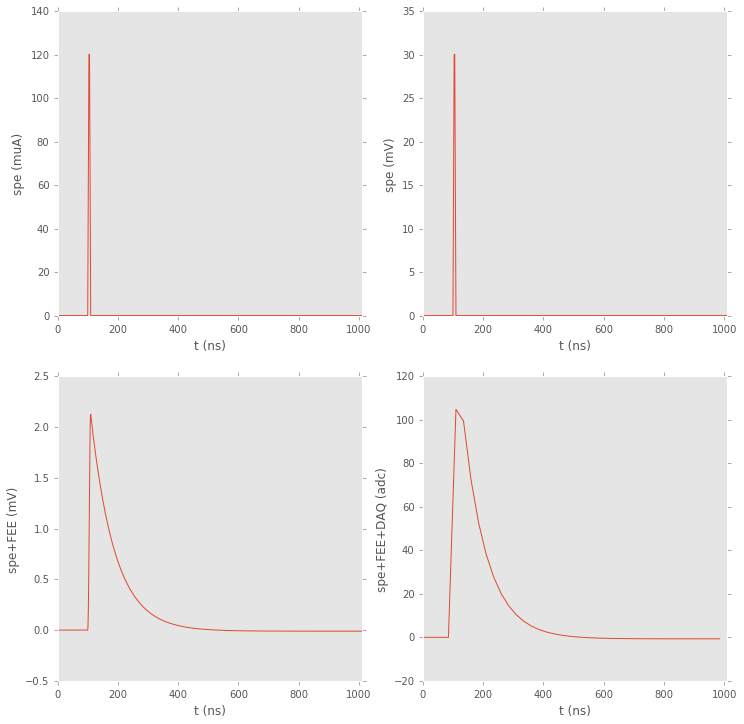

adc counts per spe = 436.923501543


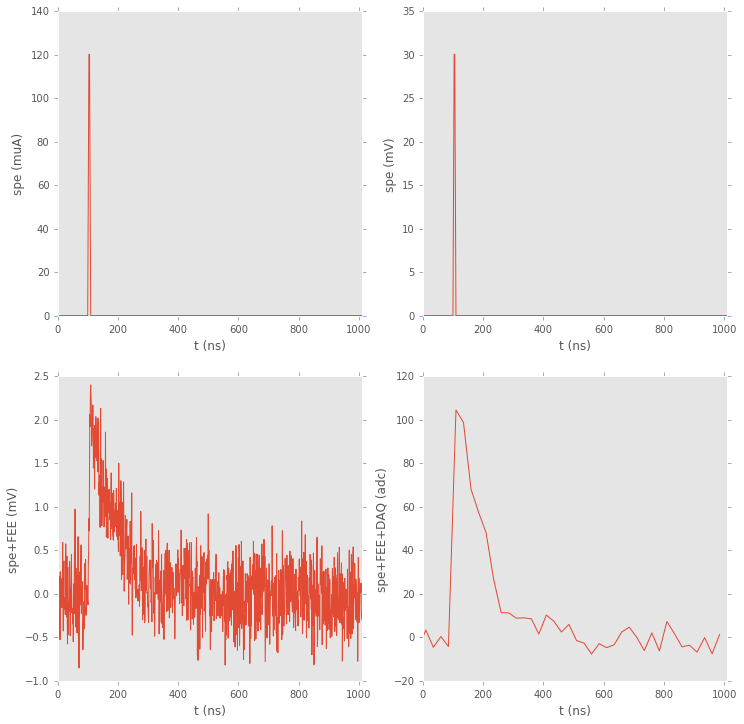

adc counts per spe = 877024.575692


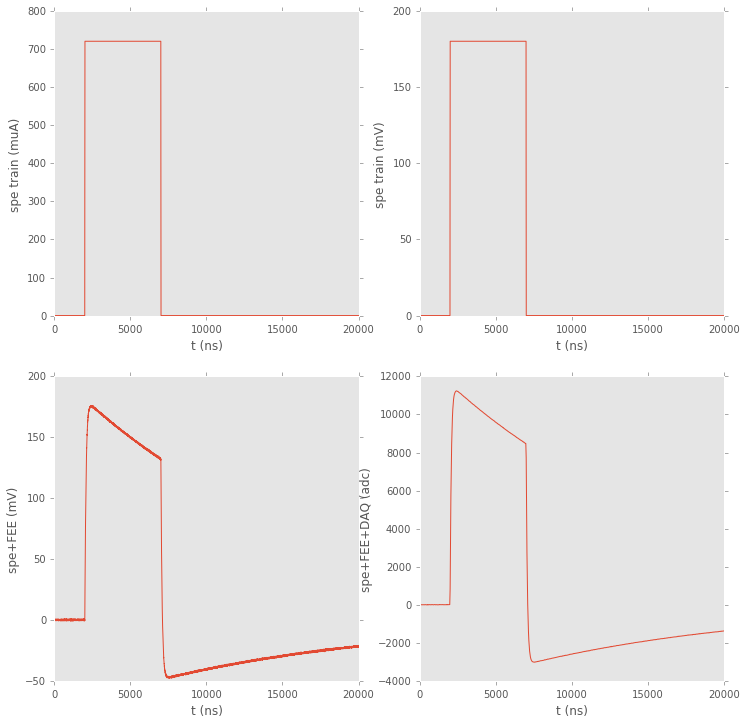

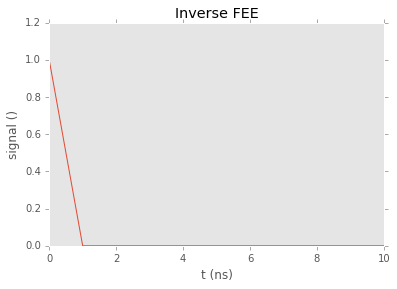

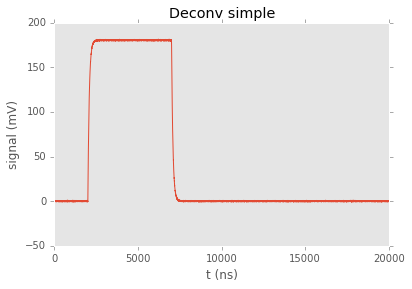

In [23]:
# %load ../../Sierpe/FEE2.py
from __future__ import print_function
from Util import *
import mplFunctions as mpl
import FEParam as FP
import SPE as SP
from scipy import signal as SGN
import numpy as np
#from deModel import arrayFixedInt
#from deModel import DeFixedInt


def DownScaleSignal(signal_t, signal, scale):
 	"""
 	downscales the time and signal vectors
 	"""
	signal_d=SGN.decimate(signal,scale,ftype='fir')
	signal_t_d = SGN.decimate(signal_t,scale,ftype='fir')

	#pulse_plot(signal_t_d, signal_d)
	return signal_t_d, signal_d

def down_scale_signal_(signal, scale):
 	"""
    downscales the signal vector. Re-scale the energy
 	"""
	signal_d=SGN.decimate(signal,scale,ftype='fir')

	#return signal_d*scale
	return signal_d

def DeconvSimple(signal,signal_inv):
	"""
	Deconvolution of the fine-grained fee signal (no DAQ)
	no noise
	using true start and end of signals
	"""

	coef = signal_inv[100]

	acum = np.zeros(len(signal))

	acum[0]=coef*signal[0]
	for n in xrange(1,len(signal)):
		acum[n] = acum[n-1] + signal[n]

	signal_r = signal + coef*acum

	return signal_r


##########################################################
class Filter:

 	def __init__(self,ftype='high',fc=5E3,fs= 1e+9):
		"""
		Defines a Butterworth HPF (high pass frequency) or LPF (low pass frequencey) filter
		the default sampling frequencey is 1 GHz (inverse of 1 ns time)
		type may be equal to hig or low
		"""
		self.fc = fc
		self.fs = fs
		self.W = 2*self.fc/self.fs
		self.ftype = ftype
		self.b, self.a = SGN.butter(1, self.W, btype=self.ftype, analog=False, output='ba')
		self.ba, self.aa = SGN.butter(1, 2*self.fc, btype=self.ftype, analog=True, output='ba')

	def FilterCoef(self):
		"""
		Returns the filter coefficients
		"""
  		return self.b,self.a

  	def FilterAnalogCoef(self):
		"""
		Returns the filter coefficients
		"""
  		return self.ba,self.aa

	def FilterPulse(self,pulse):
		"""
		Filters a pulse
		"""
  		return SGN.lfilter(self.b,self.a, pulse)

  	def FilterResponse(self):
  		"""
  		Gives the response of the filter y frequency-amplitude
  		"""

  		self.w, self.h = SGN.freqs(self.ba, self.aa)
  		return self.w, self.h


	def __str__(self):

		s= """
		Filter:
		fc = %7.2f Hz, fs = %7.2f, W = %7.2f Hz type = %s
		"""%(self.fc, self.fs, self.W, self.ftype)
		return s



###########################################################

class FEE:
	"""
	Emulates the effect of the PMT + FEE:
	1) PMT gain G
	2) A HPF, due to the FEE decoupling capacitor C and the associated series resitor R
	3) A LPF that shapes the signal, with a frequencey f and a noise
	4) A resitor gain RG to transform current in voltage
	"""

 	def __init__(self,PMTG=4.5e6, C=6.75*nF,R= 2350*ohm, f=2E6*hertz, RG=250*ohm):

 		self.PMTG = PMTG
 		self.C = C
 		self.R = R
 		self.f_LPF = f
 		self.RG = RG
 		self.f_HPF=(1./(2*pi*R*C))
 		self.hpf = Filter(ftype='high',fc=self.f_HPF,fs=FP.f_sample)
		self.lpf = Filter(ftype='low',fc=self.f_LPF,fs=FP.f_sample)
		self.hpfr = Filter(ftype='high',fc=self.f_HPF,fs=FP.f_sample_DAQ)


	def Filter(self,signal):
		"""
		for an input signal in pes, returns the effect of the electronics
		"""
		signal_hp = self.hpf.FilterPulse(signal)
		signal_lp = self.lpf.FilterPulse(signal)
		signal_hp_lp = self.lpf.FilterPulse(signal_hp)
		return signal_lp, signal_hp, signal_hp_lp

  	def FilterInverse(self, signal):
  		"""
  		Returns the inverse of the HPF filter in bins of 1ns
  		"""
  		b_HPr,a_HPr = self.hpf.FilterCoef()
		h_t_inv = SGN.lfilter(a_HPr,b_HPr, signal)
		return h_t_inv

	def FilterInverseDAQ(self, signal):
		"""
		Returns the inverse of the HPF filter in bins of time_DAQ (25 ns)
		"""
  		b_HPr,a_HPr = self.hpfr.FilterCoef()
		h_t_inv = SGN.lfilter(a_HPr,b_HPr, signal)
		return h_t_inv

	def FEESignal(self,signal_current, noise_rms=0.3*mV):
 		"""
 		filters the input signal according to the filters and transforms it in volts
 		"""
 		signal_lp, signal_hp, signal_hp_lp = self.Filter(signal_current)
 		noise = self.FEENoise(len(signal_current), noise_rms)
 		return signal_hp_lp*self.RG + noise

	def BLRSignal(self,signal_current, noise_rms=0.3*mV):
 		"""
 		filters the input signal according to the filters and transforms it in volts
 		"""
 		signal_lp, signal_hp, signal_hp_lp = self.Filter(signal_current)
 		noise = self.FEENoise(len(signal_current), noise_rms)
 		return signal_lp*self.RG + noise


 	def DAQSignal(self,signal_t, signal_fee, noise_rms=0.3*mV):
 		"""
 		downscale the signal after the FEE

 		"""

		signal_t_d, signal_d = DownScaleSignal(signal_t, signal_fee, int(FP.time_DAQ))
		signal_daq = signal_d/FP.voltsToAdc
		noise = self.FEENoise(len(signal_daq), noise_rms/FP.voltsToAdc)
 		return signal_t_d, signal_daq + noise

 	def daqSignal(self,signal_fee, noise_rms=FP.NOISE_FEE_rms):
 		"""
 		downscale the signal after the FEE

 		"""

		signal_d = down_scale_signal_(signal_fee, int(FP.time_DAQ))
		signal_daq = signal_d/FP.voltsToAdc
		noise = self.FEENoise(len(signal_daq), noise_rms/FP.voltsToAdc)
 		return signal_daq + noise

 	def FEENoise(self, signal_length, noise_rms=FP.NOISE_FEE_rms):
 		"""
 		filters the input signal according to the filters and transforms it in volts
 		"""
 		if noise_rms > 0:
 			noise = np.random.normal(0, noise_rms, signal_length)
 			return noise
 		else:
 			return np.zeros(signal_length)


 	def VSignal(self,signal_current):
 		"""
 		Takes a current input signal and transforms it to volts
 		"""
 		return signal_current*self.RG

 	def InverseSignal(self, signal_t):
 		"""
 		Computes the inverse signal for deconvolution
 		"""
		pulse = np.zeros(len(signal_t))
		pulse[0]=1

		signal_fee_inv = self.FilterInverse(pulse)
		return signal_fee_inv

	def InverseSignalDAQ(self, signal_t):
		"""
		Computes the inverse signal in bins of DAQ
		"""
		pulse = np.zeros(len(signal_t))
		pulse[0]=1

		signal_daq_inv = self.FilterInverseDAQ(pulse)
		return signal_daq_inv

 	def __str__(self):

		s= """
		NEW FEE
  		PMT gain = %7.2g
  		decoupling capacitor = %7.2f nF
  		decoupling resistor = %7.2f ohm
  		resitor gain = %7.2f ohm
  		HPF frequency = %7.2g Hz  W_HPF = %7.2g
  		LPF frequency = %7.2g Hz  W_LPF = %7.2g
  """%(self.PMTG,self.C/nF,self.R/ohm, self.RG/ohm,
  		self.f_HPF/hertz,self.hpf.W,
  		self.f_LPF/hertz, self.lpf.W)

		return s





if __name__ == '__main__':
	fee = FEE()
	print(fee)
	single_pe(start_pulse=100*ns, end_pulse=1000*ns,noise=0)
	single_pe(start_pulse=100*ns, end_pulse=1000*ns,noise=0.3*mV)
	signal_t, signal_fee = pulse_train()
	signal_fee_inv = fee.InverseSignal(signal_t)
	mpl.plot_signal(signal_t/ns,signal_fee_inv,
                title = 'Inverse FEE',
                signal_start=0*ns, signal_end=10*ns,
                units='')
	signal_r = DeconvSimple(signal_fee,signal_fee_inv)
	mpl.plot_signal(signal_t/ns,signal_r/mV,
                	title = 'Deconv simple',
                	signal_start=0, signal_end=len(signal_t),
                	units='mV')


In [26]:
def single_pe(start_pulse=100*ns, end_pulse=500*ns, noise=FP.NOISE_FEE_rms):
    spe = SP.SPE()
    fee = FEE()
    # PMT response to a single photon (single pe current pulse)
    signal_t, signal_PE =spe.SpePulse(start_pulse, tmax=end_pulse)
    # spe in voltage (without FEE)
    signal_PE_v = fee.VSignal(signal_PE)
    #effect of FEE
    signal_fee = fee.FEESignal(signal_PE, noise_rms=noise)
    #effect of DAQ
    signal_t_daq, signal_daq = fee.DAQSignal(signal_t, signal_fee, noise_rms=0)
    #signal_daq *=FP.time_DAQ #re-scale by decimation factor
    plt.figure(figsize=(12,12))

    ax1 = plt.subplot(2,2,1)
    ax1.set_xlim([0, len(signal_t)])
    mpl.SetPlotLabels(xlabel='t (ns)', ylabel='spe (muA)')
    plt.plot(signal_t, signal_PE/muA)

    ax2 = plt.subplot(2,2,2)
    ax2.set_xlim([0, len(signal_t)])
    mpl.SetPlotLabels(xlabel='t (ns)', ylabel='spe (mV)')
    plt.plot(signal_t, signal_PE_v/mV)

    ax3 = plt.subplot(2,2,3)
    ax3.set_xlim([0, len(signal_t)])
    mpl.SetPlotLabels(xlabel='t (ns)', ylabel='spe+FEE (mV)')
    plt.plot(signal_t, signal_fee/mV)

    ax4 = plt.subplot(2,2,4)
    ax4.set_xlim([0, len(signal_t)])
    mpl.SetPlotLabels(xlabel='t (ns)', ylabel='spe+FEE+DAQ (adc)')
    plt.plot(signal_t_daq, signal_daq)

    area = np.sum(signal_daq)
    print("adc counts per spe = {}".format(area))

    plt.show()

adc counts per spe = 17.6938453605


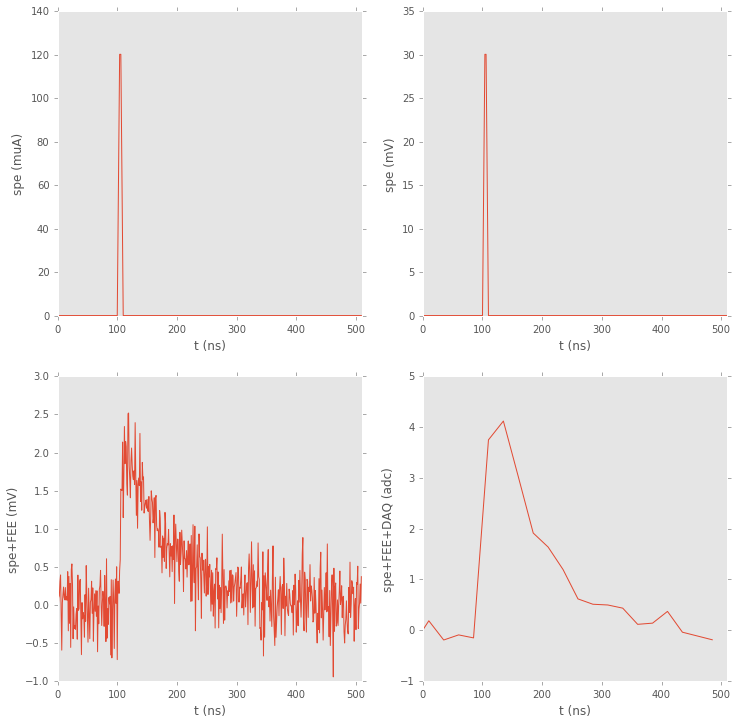

In [27]:
single_pe()

In [28]:
def single_pe_blr(start_pulse=100*ns, end_pulse=500*ns, noise=FP.NOISE_FEE_rms):
    spe = SP.SPE()
    fee = FEE()
    # PMT response to a single photon (single pe current pulse)
    signal_t, signal_PE =spe.SpePulse(start_pulse, tmax=end_pulse)
    # spe in voltage (without FEE)
    signal_PE_v = fee.VSignal(signal_PE)
    #effect of FEE
    signal_fee = fee.BLRSignal(signal_PE, noise_rms=noise)
    #effect of DAQ
    signal_t_daq, signal_daq = fee.DAQSignal(signal_t, signal_fee, noise_rms=0)
    #signal_daq *=FP.time_DAQ #re-scale by decimation factor
    plt.figure(figsize=(12,12))

    ax1 = plt.subplot(2,2,1)
    ax1.set_xlim([0, len(signal_t)])
    mpl.SetPlotLabels(xlabel='t (ns)', ylabel='spe (muA)')
    plt.plot(signal_t, signal_PE/muA)

    ax2 = plt.subplot(2,2,2)
    ax2.set_xlim([0, len(signal_t)])
    mpl.SetPlotLabels(xlabel='t (ns)', ylabel='spe (mV)')
    plt.plot(signal_t, signal_PE_v/mV)

    ax3 = plt.subplot(2,2,3)
    ax3.set_xlim([0, len(signal_t)])
    mpl.SetPlotLabels(xlabel='t (ns)', ylabel='spe+FEE (mV)')
    plt.plot(signal_t, signal_fee/mV)

    ax4 = plt.subplot(2,2,4)
    ax4.set_xlim([0, len(signal_t)])
    mpl.SetPlotLabels(xlabel='t (ns)', ylabel='spe+FEE+DAQ (adc)')
    plt.plot(signal_t_daq, signal_daq)

    area = np.sum(signal_daq)
    print("adc counts per spe = {}".format(area))

    plt.show()

adc counts per spe = 19.7030253964


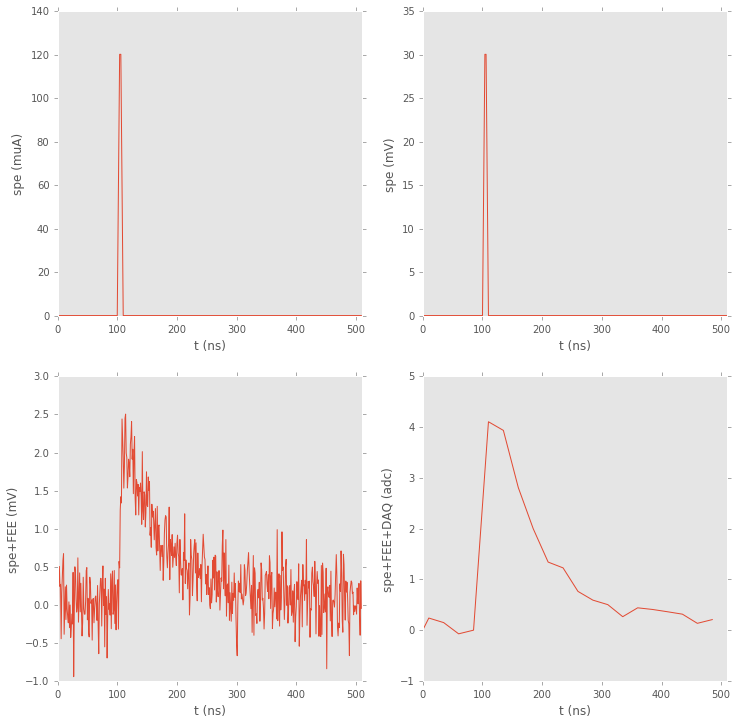

In [29]:
single_pe_blr()

In [32]:
def pulse_train(signal_start=2000*ns, signal_length=5000*ns, daq_window = 20*microsecond, noise=FP.NOISE_FEE_rms):
    signal_end = signal_start + signal_length
    spe = SP.SPE()
    fee = FEE()
    # PMT response to a photon train
    signal_t, signal_PE = spe.SpePulseTrain(signal_start,signal_end,daq_window)
    # spe in voltage (without FEE)
    signal_PE_v = fee.VSignal(signal_PE)
    #effect of FEE
    signal_fee = fee.FEESignal(signal_PE, noise_rms=noise)
    #effect of DAQ
    signal_t_daq, signal_daq = fee.DAQSignal(signal_t, signal_fee, noise_rms=0)
    #signal_daq *=FP.time_DAQ #re-scale by decimation factor
    plt.figure(figsize=(12,12))

    ax1 = plt.subplot(2,2,1)
    ax1.set_xlim([0, len(signal_t)])
    mpl.SetPlotLabels(xlabel='t (ns)', ylabel='spe train (muA)')
    plt.plot(signal_t, signal_PE/muA)

    ax2 = plt.subplot(2,2,2)
    ax2.set_xlim([0, len(signal_t)])
    mpl.SetPlotLabels(xlabel='t (ns)', ylabel='spe train (mV)')
    plt.plot(signal_t, signal_PE_v/mV)

    ax3 = plt.subplot(2,2,3)
    ax3.set_xlim([0, len(signal_t)])
    mpl.SetPlotLabels(xlabel='t (ns)', ylabel='spe+FEE (mV)')
    plt.plot(signal_t, signal_fee/mV)

    ax4 = plt.subplot(2,2,4)
    ax4.set_xlim([0, len(signal_t)])
    mpl.SetPlotLabels(xlabel='t (ns)', ylabel='spe+FEE+DAQ (adc)')
    plt.plot(signal_t_daq, signal_daq)

    area = np.sum(signal_daq)
    print("adc counts per spe = {}".format(area))

    plt.show()
    return signal_t, signal_fee




adc counts per spe = 35078.0749057


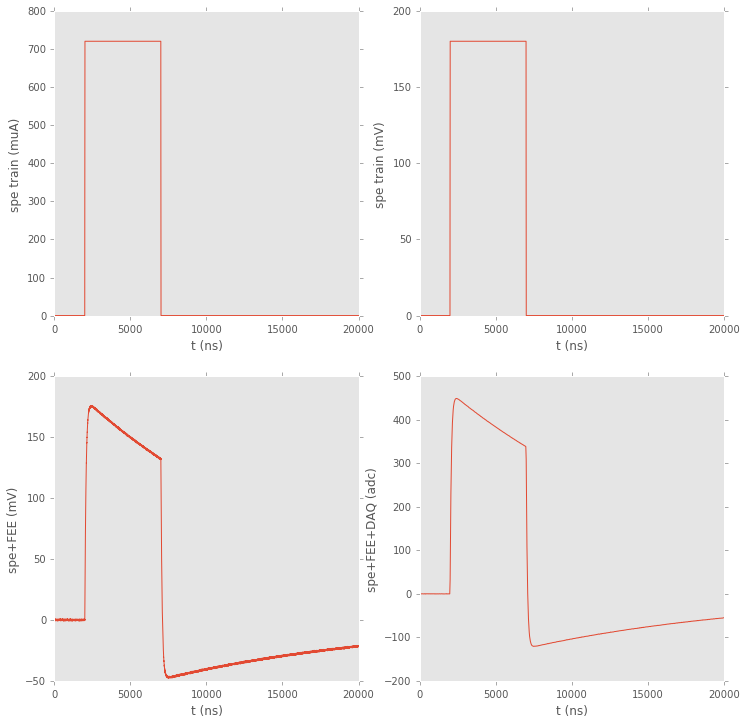

In [33]:
signal_t, signal_fee =pulse_train()

In [34]:
def pulse_train_blr(signal_start=2000*ns, signal_length=5000*ns, daq_window = 20*microsecond, noise=FP.NOISE_FEE_rms):
    signal_end = signal_start + signal_length
    spe = SP.SPE()
    fee = FEE()
    # PMT response to a photon train
    signal_t, signal_PE = spe.SpePulseTrain(signal_start,signal_end,daq_window)
    # spe in voltage (without FEE)
    signal_PE_v = fee.VSignal(signal_PE)
    #effect of FEE
    signal_fee = fee.BLRSignal(signal_PE, noise_rms=noise)
    #effect of DAQ
    signal_t_daq, signal_daq = fee.DAQSignal(signal_t, signal_fee, noise_rms=0)
    #signal_daq *=FP.time_DAQ #re-scale by decimation factor
    plt.figure(figsize=(12,12))

    ax1 = plt.subplot(2,2,1)
    ax1.set_xlim([0, len(signal_t)])
    mpl.SetPlotLabels(xlabel='t (ns)', ylabel='spe train (muA)')
    plt.plot(signal_t, signal_PE/muA)

    ax2 = plt.subplot(2,2,2)
    ax2.set_xlim([0, len(signal_t)])
    mpl.SetPlotLabels(xlabel='t (ns)', ylabel='spe train (mV)')
    plt.plot(signal_t, signal_PE_v/mV)

    ax3 = plt.subplot(2,2,3)
    ax3.set_xlim([0, len(signal_t)])
    mpl.SetPlotLabels(xlabel='t (ns)', ylabel='spe+FEE (mV)')
    plt.plot(signal_t, signal_fee/mV)

    ax4 = plt.subplot(2,2,4)
    ax4.set_xlim([0, len(signal_t)])
    mpl.SetPlotLabels(xlabel='t (ns)', ylabel='spe+FEE+DAQ (adc)')
    plt.plot(signal_t_daq, signal_daq)

    area = np.sum(signal_daq)
    print("adc counts per spe = {}".format(area))

    plt.show()
    return signal_t, signal_fee

adc counts per spe = 92306.7965067


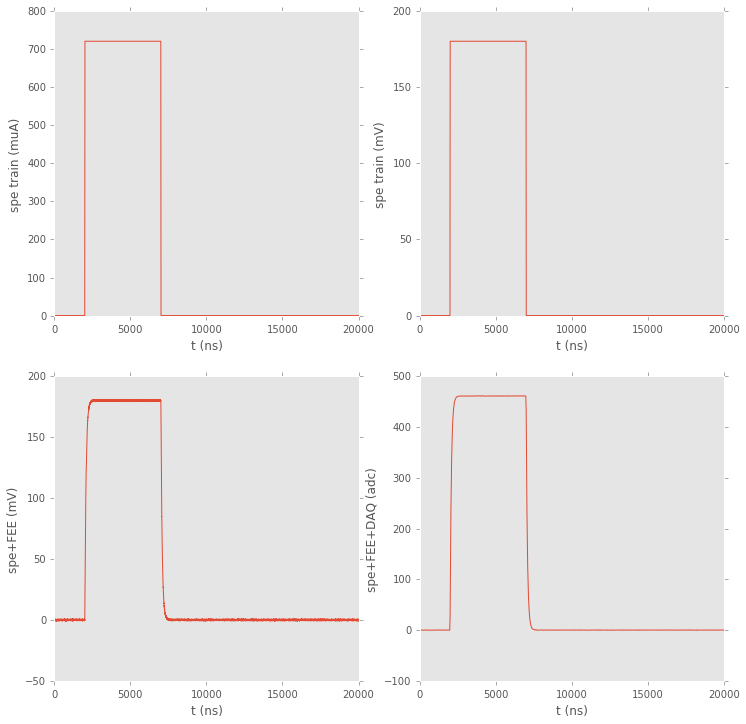

(array([  0.00000000e+00,   1.00000000e+00,   2.00000000e+00,
          3.00000000e+00,   4.00000000e+00,   5.00000000e+00,
          6.00000000e+00,   7.00000000e+00,   8.00000000e+00,
          9.00000000e+00,   1.00000000e+01,   1.10000000e+01,
          1.20000000e+01,   1.30000000e+01,   1.40000000e+01,
          1.50000000e+01,   1.60000000e+01,   1.70000000e+01,
          1.80000000e+01,   1.90000000e+01,   2.00000000e+01,
          2.10000000e+01,   2.20000000e+01,   2.30000000e+01,
          2.40000000e+01,   2.50000000e+01,   2.60000000e+01,
          2.70000000e+01,   2.80000000e+01,   2.90000000e+01,
          3.00000000e+01,   3.10000000e+01,   3.20000000e+01,
          3.30000000e+01,   3.40000000e+01,   3.50000000e+01,
          3.60000000e+01,   3.70000000e+01,   3.80000000e+01,
          3.90000000e+01,   4.00000000e+01,   4.10000000e+01,
          4.20000000e+01,   4.30000000e+01,   4.40000000e+01,
          4.50000000e+01,   4.60000000e+01,   4.70000000e+01,
        

In [35]:
pulse_train_blr()